In [123]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import particles
from particles import SMC
from particles.collectors import Moments
from particles import state_space_models as ssms
from particles import distributions as dists
from scipy.stats import invgamma
import pandas as pd

Yahoo fin S&P 500 scraping

Then, in the directory of the project run `python src/yahooscraper.py` to begin the scraping.

First implementation of the model

The model studied in the section 4. of the paper is defined as: $$ y^i_t = W^i_t \cdot \beta ^i _y + \gamma _y^i \cdot \delta ^i_t + \sqrt{\delta ^i_t} \cdot \exp(\frac{h^i_t} 2) \cdot \epsilon ^i_{y, t}$$ $$ h^i_{t+1} = \mu_h ^i + \phi_h ^i \cdot (h_t^i - \mu_h ^i)+ \sigma _h ^i \cdot \epsilon _{h,t} ^i $$
where $$ \epsilon ^i_{\cdot, t} \sim \mathcal N(0,1)$$ $$\delta ^i _t \sim \text{Inv-Gamma}(\frac{\nu_y ^i} 2, \frac{\nu_y ^i} 2)$$ $$W^i _t = (1, y^i_{t-1}, \dots, y^i_{t-k}) $$ with $k=3, 5$ depending on the type of the series studied ($3$ for equities series and $5$ for credit default swap series). We assume moreover that $$\text{Corr}(\epsilon ^i_{y, t}, \epsilon ^i_{h, t}) = \rho^i$$

The different indices respectively are:
1. $i$: the index of the time series.
2. $t$: the date of observation of the stochastic process.
3. $h$ and $y$: if whether the variable is associated to the state $h$ or the observation $y$.

**Remarks on the model**: 
- The observations are $y^i_t$ which is the log-return of the $i$-th observed time series at time $t$.
- The state variable is $(h^i_t, \delta^i_t)$ which is associated to the observation $y^i_t$.
- The article models the logreturns as SV (Stochastic Volatility) processes, $h$ can be associated with the volatility associated to the log returns.

The priors of the parameters are:
- $\mu_h^i \sim \mathcal N(0.4, 2)$
- $\phi _h ^i \sim \mathcal N(0.985, 0.001)$
- $(\sigma ^i _h )^2 \sim \text{Inv Gamma}(20, 0.25)$

## 'Rough' Simulation of the model

In [ ]:
def SV(T, mu_h, phi_h, sigma_h, rho, nu_y, beta_y, gamma_y):
    h = np.ones(T)
    y = np.ones(T)
    cov = np.array([[1, rho], [rho, 1]])
    for t in range (T-1):
        delta = invgamma.rvs(nu_y/2, scale=nu_y/2)
        eps = np.random.multivariate_normal([0, 0], cov)

        eps_y = eps[0]
        eps_h = eps[1]
        
        h[t+1] = mu_h + phi_h * (h[t] - mu_h) + sigma_h * eps_h

        W = []
        for lag in range(4):
            if t - lag >= 0:
                W.append(y[t-lag])
            else:
                W.append(0)
        W[0] = 1.0  # intercept
        W = np.array(W)

        y[t] = W.T @ beta_y + gamma_y * delta + np.sqrt(delta) * np.exp(h[t]/2) * eps_y

    return h, y

np.random.seed(42)

T = 2000

mu_h = -1.0
phi_h = 0.9
sigma_h = 0.1
rho = 0.8
nu_y = 8.0
beta_y = np.array([0, 0.1, 0.1, 0.5])
gamma_y = 0.05

h, y = SV(T, mu_h, phi_h, sigma_h, rho, nu_y, beta_y, gamma_y)

print(np.mean(y))

plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(y, label="Log Returns", linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title('Stochastic Volatility Simulation (Fixed Parameters)')
plt.legend()
plt.show()

## Simulation using particles

In [219]:
class SV(ssms.StateSpaceModel):
    """ Theta-Logistic state-space model (used in Ecology).
    """
    default_params = {'mu_h':.15, 
                      'phi_h':.8, 
                      'sigma_h': .1,
                      'beta_y': [0.1, 0.4, 0.1, 0.1],
                      'gamma_y': .05,
                      'nu_y': 8.0
    }

    def PX0(self):  # Distribution of X_0, we choose the value using the mean instead of a random value for initialization for simplicity
        return dists.IndepProd(dists.Dirac(0),
                               dists.Dirac(4/3),
                               )

    def PX(self, t, xp):  #  Distribution of X_t given X_{t-1} = xp (p=past)
        return dists.IndepProd(
            dists.Normal(loc=self.mu_h + self.phi_h * (xp[:, 0] - self.mu_h), scale=self.sigma_h),
            dists.InvGamma(a=self.nu_y/2, b=self.nu_y/2)
        )

    def PY(self, t, xp, x):  # Observation model
        if hasattr(self, 'data') and t >= 3:
            y_t_1 = self.data[t - 1]
            y_t_2 = self.data[t - 2]
            y_t_3 = self.data[t - 3]
        else:
            # Use default values or dummy covariates during simulation
            y_t_1, y_t_2, y_t_3 = 0, 0, 0
        
        intercept = 1
        W = np.array([intercept, y_t_1, y_t_2, y_t_3])
        return dists.Normal(loc=self.beta_y @ W + self.gamma_y * x[:, 1], 
                            scale=np.sqrt(x[:, 1]) * np.exp(x[:, 0] / 2))

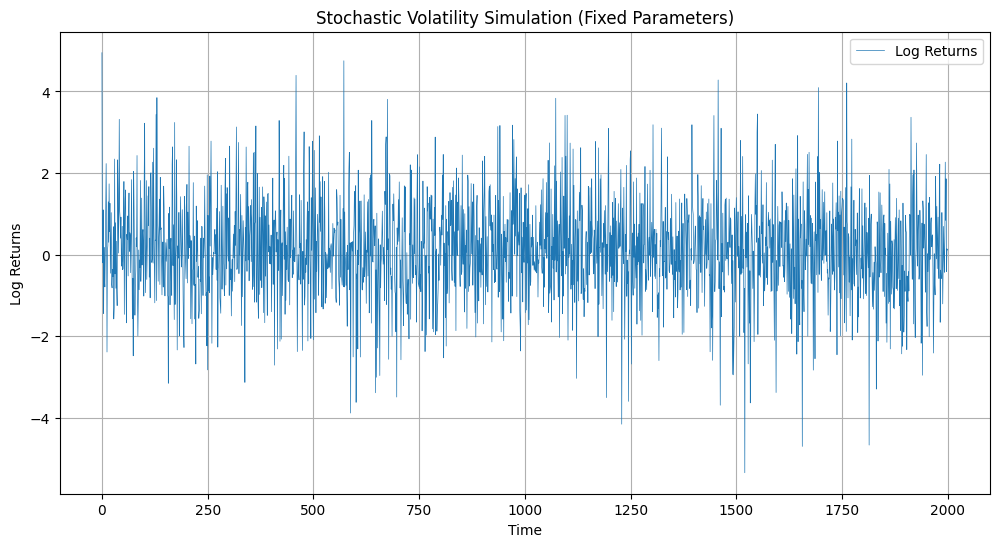

In [220]:
np.random.seed(42)
model = SV()
X, y = model.simulate(2000)
plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(y, label="Log Returns", linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title('Stochastic Volatility Simulation (Fixed Parameters)')
plt.legend()


Note that the simulated log returns are simulated in percentage (if the simulated log returns is 1, it means that the simulated asset varied of one percent i.e. 0.01).

## Importing real data for bootstraping

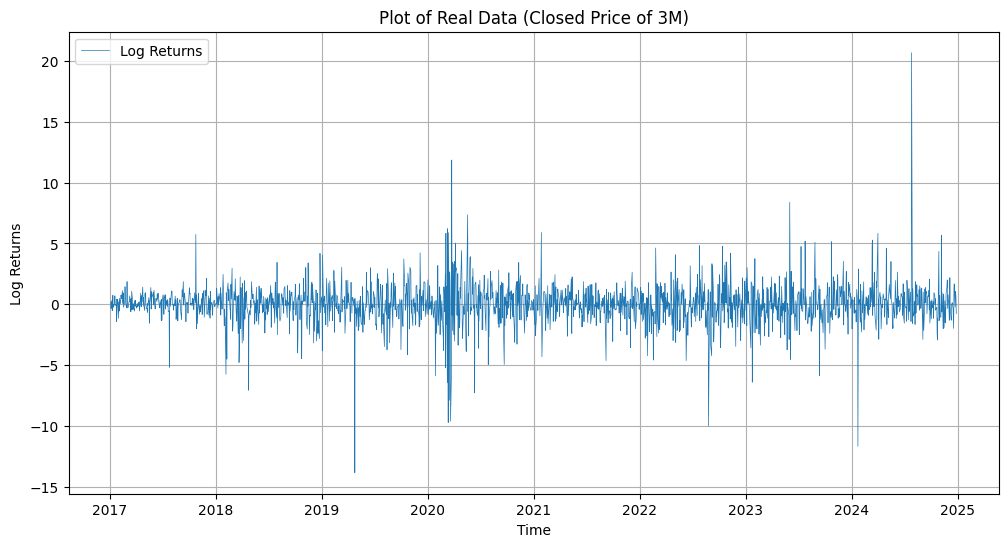

In [193]:
import pandas as pd

prices = pd.read_csv('data/sp500_prices.csv')
prices['Date'] = pd.to_datetime(prices['Date'])

company = prices['Company'].drop_duplicates().values[0]
ex_prices = prices[prices['Company'] == company][['Date', 'Close']]

price = ex_prices['Close'].values
logreturns = 100*np.log(price[1:]/ price[:-1])
dates = ex_prices['Date'].values[1:]

plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(dates, logreturns, label="Log Returns", linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title(f'Plot of Real Data (Closed Price of {company})')
plt.legend()

**Remark:** compared with the simulated processes, the real signal shows peaks. Hence, the model may not capture all the complexity of the financial time series.

## Implementing Bootstrap the Algorithm to Evaluate the Likelihood of the Model with particles

In [194]:
from particles import SMC

fk_boot = ssms.Bootstrap(ssm=model, data=100*logreturns)
pf = SMC(fk=fk_boot, N=1000, collect=[Moments()])
pf.run()

log_likelihood = pf.logLt
print("Log-Likelihood of the real data:", log_likelihood)

Log-Likelihood of the real data: -25825.778109011684


In [195]:
from tqdm import tqdm

fk_boot = ssms.Bootstrap(ssm=model, data=logreturns)
logl = []
for k in tqdm(range(1, 101)):
    np.random.seed(42)
    pf = SMC(fk=fk_boot, N=k*10, collect=[Moments()])
    pf.run()
    logl.append(pf.logLt)

100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


/var/folders/pg/mh4np6_d0qs9cxq5clx1wbbw0000gn/T/ipykernel_9657/1217308716.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


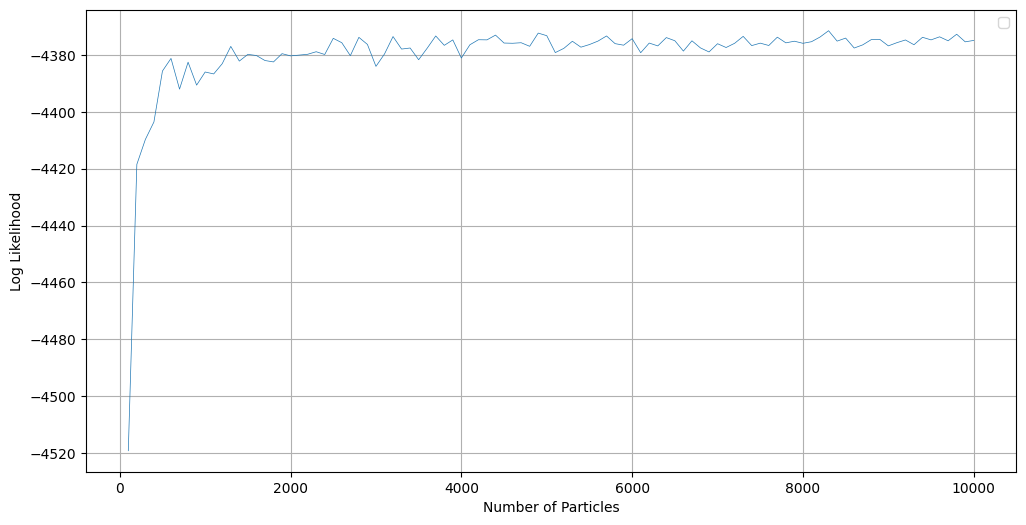

In [196]:
plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(100*np.arange(1, 101), logl, linewidth=0.5)
plt.xlabel('Number of Particles')
plt.ylabel('Log Likelihood')
plt.legend()

One can notice that $(h_t)_{t\in \mathbb N}$ is an AR(1) process, then it would be interesting to see how the likelihood behaves when $\phi_h$ varies.

In [ ]:

# Define the SV model class
class SV(ssms.StateSpaceModel):
    default_params = {'mu_h': .15,
                      'phi_h': .8,
                      'sigma_h': .1,
                      'beta_y': [0.1, 0.4, 0.1, 0.1],
                      'gamma_y': .05,
                      'nu_y': 8.0}

    def PX0(self):
        return dists.IndepProd(dists.Dirac(0), dists.Dirac(4 / 3))

    def PX(self, t, xp):
        return dists.IndepProd(
            dists.Normal(loc=self.mu_h + self.phi_h * (xp[:, 0] - self.mu_h), scale=self.sigma_h),
            dists.InvGamma(a=self.nu_y / 2, b=self.nu_y / 2),
        )

    def PY(self, t, xp, x):
        if hasattr(self, 'data') and t >= 3:
            y_t_1 = self.data[t - 1]
            y_t_2 = self.data[t - 2]
            y_t_3 = self.data[t - 3]
        else:
            y_t_1, y_t_2, y_t_3 = 0, 0, 0
        intercept = 1
        W = np.array([intercept, y_t_1, y_t_2, y_t_3])
        return dists.Normal(loc=self.beta_y @ W + self.gamma_y * x[:, 1],
                            scale=np.sqrt(x[:, 1]) * np.exp(x[:, 0] / 2))


# Parameters to evaluate
param_ranges = {
    'mu_h': np.linspace(0, 1, 100),
    'phi_h': np.linspace(-1, 1, 100),
    'sigma_h': np.linspace(0.01, 1, 100),
    'gamma_y': np.linspace(0.01, 1, 100),
    'nu_y': np.linspace(5, 15, 100),
}

# Fixed parameters for the model
fixed_params = SV.default_params

# Store results
log_likelihoods = {}

# Perform evaluation for each parameter
for param, values in param_ranges.items():
    log_likelihoods[param] = []
    for val in tqdm(values, desc=f"Evaluating {param}"):
        # Update the parameter
        params = fixed_params.copy()
        params[param] = val
        model = SV(**params)
        
        # Run the bootstrap filter
        np.random.seed(42)
        fk_boot = ssms.Bootstrap(ssm=model, data=logreturns)
        pf = SMC(fk=fk_boot, N=2000)
        pf.run()
        
        # Store the log-likelihood
        log_likelihoods[param].append(pf.logLt)


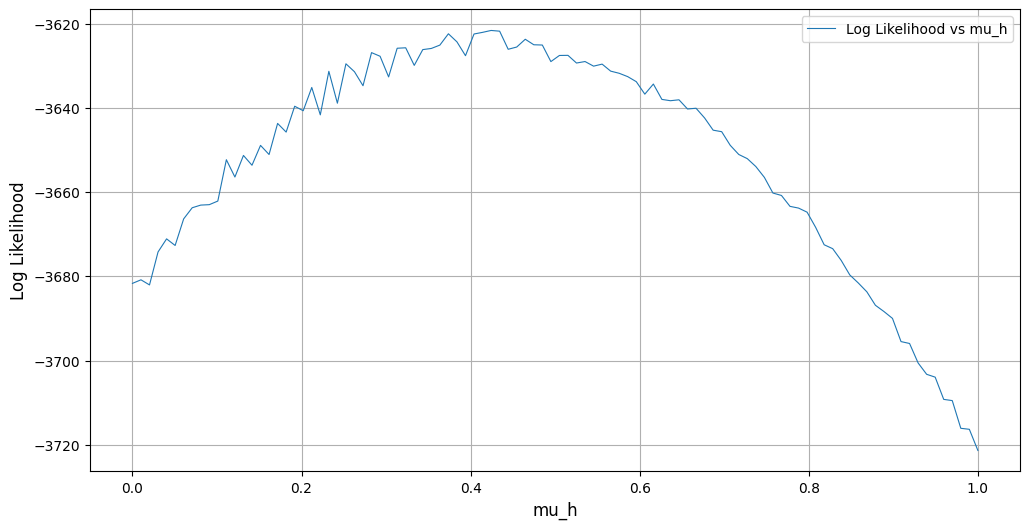

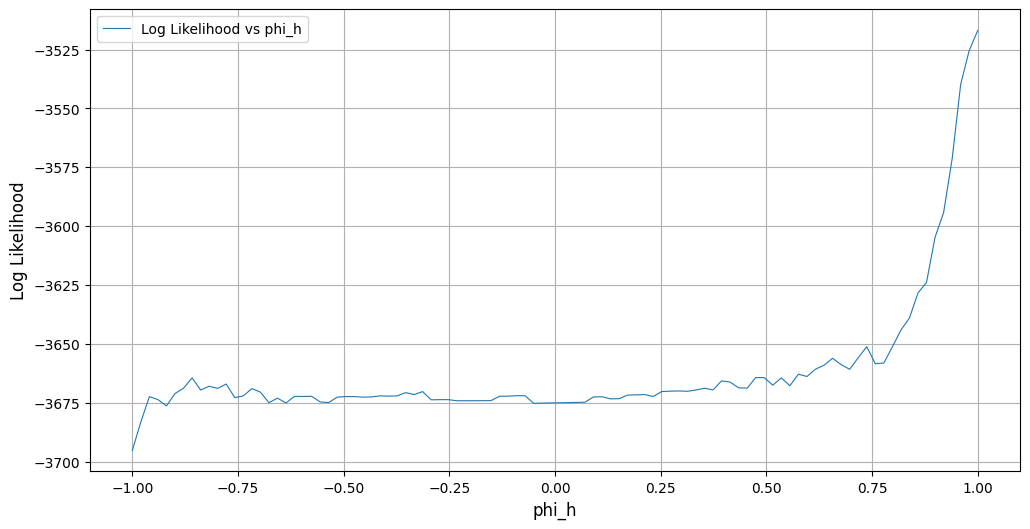

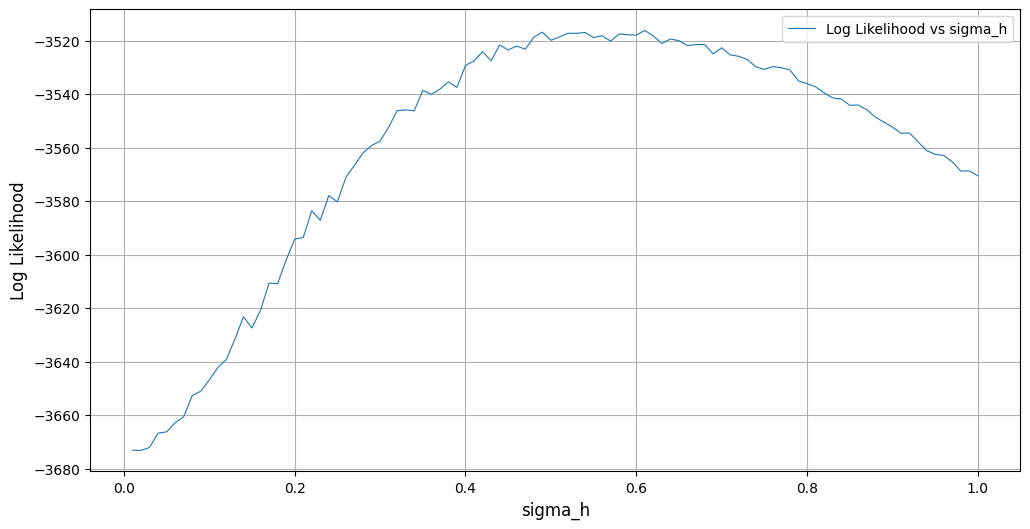

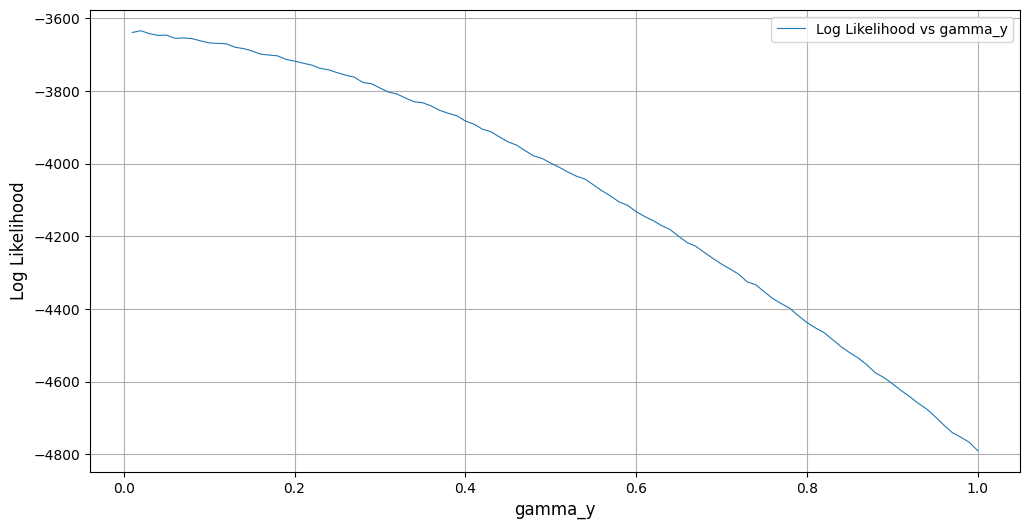

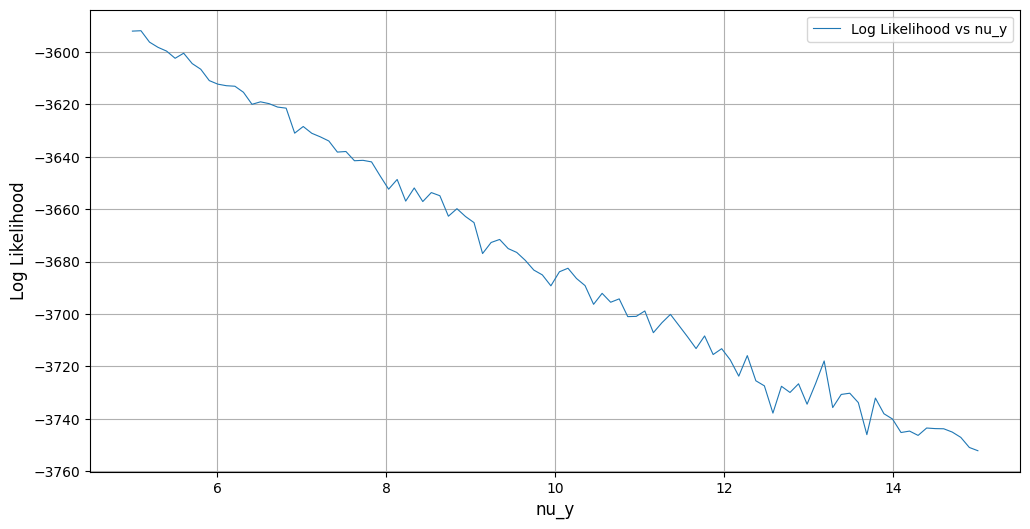

In [227]:
# Plot results
for i, (param, values) in enumerate(param_ranges.items()):
    plt.figure(figsize=(12, 6))
    plt.plot(values, log_likelihoods[param], label=f'Log Likelihood vs {param}', linewidth=0.8)
    plt.xlabel(f'{param}', fontsize=12)
    plt.ylabel('Log Likelihood', fontsize=12)
    plt.grid()
    plt.legend()
    plt.show()

Note that here we plot the variation of the parameters one by one. This is an indicative plot but does not account for the interaction effects between parameters. In practice, studying the log-likelihood while varying all parameters simultaneously is infeasible due to the high dimensionality of the parameter space. Each additional parameter exponentially increases the computational cost, making a full exploration of the parameter space impractical.

Instead, one-dimensional plots like these provide a simplified view to understand the individual effect of each parameter on the log-likelihood.

## Parameters optimiization using scipy

Optimization for this problem is a real hardship due to the huge number of parameters and the sensitivity of the model. One way we choose to achieve this was to start from different initial guesses and then run an optimization.

In [ ]:
from scipy.optimize import minimize
import numpy as np
from particles import SMC
from particles.collectors import Moments
from particles import state_space_models as ssms


# Modify the model class to allow parameter updates
class SV(ssms.StateSpaceModel):
    default_params = {
        'mu_h': 0.15,
        'phi_h': 0.12,
        'sigma_h': 1,
        'rho_h': 0.3,
        'beta_y': [0.1, 0.1, 0.1, 0.1],
        'gamma_y': 1,
        'nu_y': 8.0
    }

    def PX0(self):
        return dists.IndepProd(dists.Dirac(0), dists.Dirac(4 / 3))

    def PX(self, t, xp):
        return dists.IndepProd(
            dists.Normal(loc=self.mu_h + self.phi_h * (xp[:, 0] - self.mu_h), scale=self.sigma_h),
            dists.InvGamma(a=self.nu_y / 2, b=self.nu_y / 2),
        )

    def PY(self, t, xp, x):
        if hasattr(self, 'data') and t >= 3:
            y_t_1 = self.data[t - 1]
            y_t_2 = self.data[t - 2]
            y_t_3 = self.data[t - 3]
        else:
            y_t_1, y_t_2, y_t_3 = 0, 0, 0
        intercept = 1
        W = np.array([intercept, y_t_1, y_t_2, y_t_3])
        return dists.Normal(loc=self.beta_y @ W + self.gamma_y * x[:, 1], 
                            scale=np.sqrt(x[:, 1]) * np.exp(x[:, 0] / 2))


# Objective function for optimization (includes nu and beta_y)
def objective(params):
    # Map parameters to the model
    model = SV(
        mu_h=params[0],
        phi_h=params[1],
        sigma_h=params[2],
        gamma_y=params[3],
        nu_y=params[4],  # Optimizing nu
        beta_y=params[5:9],  # Optimizing beta_y (4 parameters)
    )
    
    # Run the Bootstrap filter
    np.random.seed(42)
    fk_model = ssms.Bootstrap(ssm=model, data=logreturns)
    pf = SMC(fk=fk_model, N=500)
    pf.run()
    
    # Return the negative log-likelihood
    return -pf.logLt


# Initial parameter guesses
initial_params = [
    0.15,  # mu_h
    0.12,  # phi_h
    1.0,   # sigma_h
    1.0,   # gamma_y
    8.0,   # nu_y
    0.1, 0.1, 0.1, 0.1  # beta_y (4 coefficients)
]

# Bounds for parameters (adjust based on your model and domain knowledge)
param_bounds = [
    (0, 1),    # mu_h
    (0, .9),    # phi_h
    (0.1, 2),  # sigma_h
    (0.1, 2),  # gamma_y
    (1, 20),   # nu_y
    (-1, 1), (-1, 1), (-1, 1), (-1, 1)  # beta_y (4 coefficients)
]

# Perform optimization

initial_guesses = [
    [0.15, 0.12, 1.0, 1.0, 8.0, 0.1, 0.1, 0.1, 0.1],  # Original guess
    [0.2, 0.1, 0.9, 1.2, 10.0, -0.1, 0.2, -0.2, 0.3],  # Slightly perturbed
    [0.1, 0.2, 1.5, 0.8, 5.0, 0.5, -0.3, 0.3, -0.1],  # More diverse guess
    [0.3, 0.05, 1.1, 1.5, 15.0, -0.5, 0.4, -0.4, 0.2]  # High variation
]

# Store results
results = []

# Perform optimization for each initial guess
for idx, guess in enumerate(initial_guesses):
    print(f"Running optimization for initial guess {idx + 1}...")
    
    # Run basinhopping with the current initial guess
    result = minimize(objective, guess, bounds=param_bounds, method='Powell')
    
    # Store the result
    results.append({
        'initial_guess': guess,
        'optimized_params': result.x,
        'max_log_likelihood': -result.fun
    })


In [225]:
for idx, result in enumerate(results):
    print('initial_guess', result['initial_guess'])
    print('optimized parameters', result['optimized_params'])
    print('max_log_likelihood', result['max_log_likelihood'], '\n')

initial_guess [0.15, 0.12, 1.0, 1.0, 8.0, 0.1, 0.1, 0.1, 0.1]
optimized parameters [ 0.34359372  0.84151472  0.58562769  0.34375605 15.02022847 -0.23409161
  0.95800519  0.95800519  0.95800519]
max_log_likelihood -3520.446958837625 

initial_guess [0.2, 0.1, 0.9, 1.2, 10.0, -0.1, 0.2, -0.2, 0.3]
optimized parameters [ 0.22755989  0.75370104  0.69101475  0.48814149 18.57609081 -0.38506947
  0.9094094   0.86413555  0.92072786]
max_log_likelihood -3520.4868252142933 

initial_guess [0.1, 0.2, 1.5, 0.8, 5.0, 0.5, -0.3, 0.3, -0.1]
optimized parameters [ 0.37781242  0.83565772  0.58481082  0.26940862 11.89478452 -0.20503271
  0.95261068  0.97446116  0.95989418]
max_log_likelihood -3511.887610270407 

initial_guess [0.3, 0.05, 1.1, 1.5, 15.0, -0.5, 0.4, -0.4, 0.2]
optimized parameters [ 0.30422825  0.77738781  0.67408871  0.72694738 17.24120534 -0.64789216
  0.9498112   0.88295191  0.93309637]
max_log_likelihood -3525.325959759863 



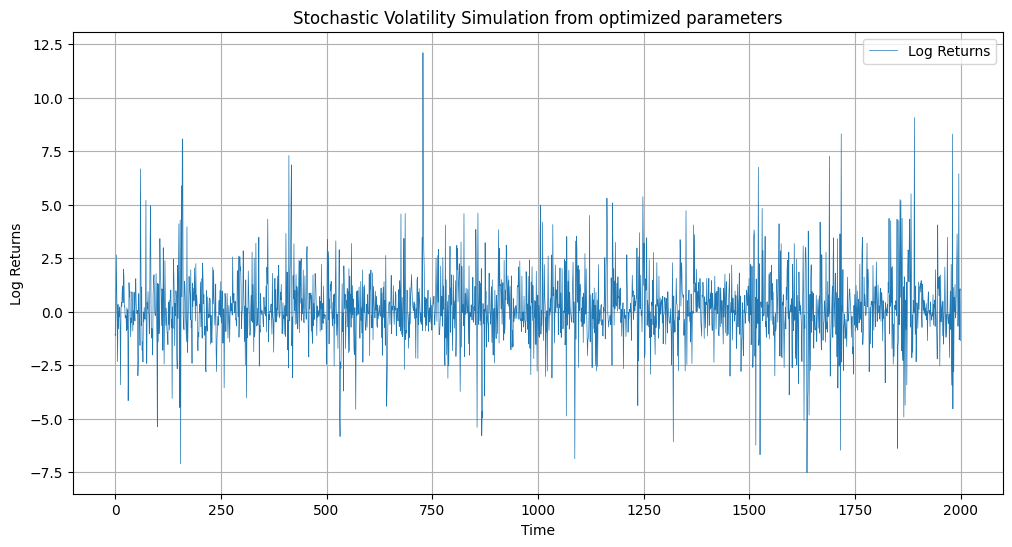

In [224]:
optimized_params = results[-1]['optimized_params']
model = SV(
    mu_h=optimized_params[0],
    phi_h=optimized_params[1],
    sigma_h=optimized_params[2],
    gamma_y=optimized_params[3],
    nu_y=optimized_params[4],  # Optimizing nu
    beta_y=optimized_params[5:9],  # Optimizing beta_y (4 parameters)
)

X, y = model.simulate(2000)
plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(y, label="Log Returns", linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title('Stochastic Volatility Simulation from optimized parameters')
plt.legend()

Note this simulation is way more realistic than 